# Activation Functions

I tried to train a MLP on MNIST using various activation functions. These activation functions are :

* Sine : $f(x) = \sin(x)$
* Cosine : $f(x) = \cos(x)$
* ReLU : $f(x) = \max(0,x)$
* ReSU: $f(x) = \max \left(0, \mathrm{sign}(x) * \sqrt{|x|}\right)$
* ReLogU : $f(x) = \max\left(0, \mathrm{sign}(x) * \log(1+|x|) \right)$
* Leaky ReLu : $f(x) = \max(x, \alpha x)$, $\alpha \le 1$
* Sigmoid : $f(x) = \sigma(x) = \frac{1}{1 + \exp(-x)}$
* Tanh : $f(x) = \tanh(x) = \frac{\exp(x) - \exp(-x)}{\exp(x) + \exp(-x)}$
* SimLog : $f(x) = \mathrm{sign}(x) * \log(1 + |x|)$
* SimSqrt : $f(x) = \mathrm{sign}(x) * \sqrt{|x|}$


### Importing modules

In [13]:
import torch
from torch import optim
from torch.autograd import Variable
from torch import nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import sys
import os

use_cuda = torch.cuda.is_available()

### Defining hyperparameters

In [16]:
input_size = 784
h1 = 500
h2 = 500
output_size = 10

batch_size = 32
n_epochs = 25
results_dir = './results/'

if not os.path.exists(results_dir):
    os.mkdir(results_dir)

### Loading MNIST dataset

In [6]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision import transforms

transform = transform = transforms.Compose([transforms.ToTensor(),
                                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#downloading datasets
training_set = MNIST('./mnist', train=True, download=True, transform=transform)
valid_set = MNIST('./mnist', train=True, download=True, transform=transform)
test_set = MNIST('./mnist', train=False, download=True, transform=transform)

num_train = len(training_set)
valid_size = len(test_set)          #valid set same size as test set
indices = list(range(num_train))

#shuffling the indices to sample training and valid dataset
np.random.seed(0)
np.random.shuffle(indices)

train_idx, valid_idx = indices[valid_size:], indices[:valid_size]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

dataloaders = {'train': DataLoader(training_set, batch_size=batch_size, sampler=train_sampler),
               'valid': DataLoader(valid_set, batch_size=batch_size, sampler=valid_sampler),
               'test': DataLoader(test_set, batch_size=batch_size)}


### Building model

In [21]:
class CustomActvClf(nn.Module):
    
    def __init__(self, actv, input_size=784, h1=500, h2=500, output_size=10, name='model'):
        super(CustomActvClf, self).__init__()
        
        self.actv = actv()
        self.name = name
        
        self.input_size = input_size
        self.h1 = h1
        self.h2 = h2
        self.output_size = output_size
        
        self.fc1 = nn.Linear(input_size, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, output_size)
    
    def forward(self, x):
        
        x = self.actv(self.fc1(x))
        x = self.actv(self.fc2(x))
        x = self.fc3(x)
        
        return x

### Defining training and evaluation functions

In [17]:
def train(model, dataloaders, n_epochs, learning_rate=1e-3):
    
    if use_cuda:
        model = model.cuda()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    #empty lists to track progress of loss and accuracy of datasets
    loss_tracker = []
    train_acc_tracker = []
    valid_acc_tracker = []
    test_acc_tracker = []

    for epoch in range(n_epochs):
        
        model.train()
        
        epoch_loss = 0
        n_correct = 0
        n_examples = 0
        
        for inputs, targets in dataloaders['train']:
            
            optimizer.zero_grad()
            
            inputs = inputs.view(-1, model.input_size)
            inputs, targets = Variable(inputs), Variable(targets)
            
            if use_cuda:
                inputs, targets = inputs.cuda(), targets.cuda()
                
            outputs = model(inputs)
            
            loss = criterion(outputs, targets)
#             epoch_loss += loss.data[0]     # for PyTorch 0.3.0
            epoch_loss += loss.item()     # for PyTorch 0.4.0
            loss.backward()
            optimizer.step()
            
            _, predictions = outputs.max(1)
#             n_correct += torch.sum(torch.eq(predictions, targets)).data[0]  # for PyTorch 0.3.0
            n_correct += torch.sum(torch.eq(predictions, targets)).item()   # for PyTorch 0.4.0
            n_examples += len(inputs)
        
        loss_tracker.append(epoch_loss / len(dataloaders['train']))
        train_acc_tracker.append((n_correct / n_examples) * 100)
        valid_acc_tracker.append(evaluate(model, dataloaders['valid']))
        
        print("Epoch : %d ----- Loss : %.2f ----- Train acc : %.2f%% ----- Valid acc : %.2f%%"
              % (epoch, loss_tracker[-1], train_acc_tracker[-1], valid_acc_tracker[-1]))
        
    np.savetxt(results_dir + model.name + '_loss.txt', loss_tracker)
    np.savetxt(results_dir + model.name + '_train_acc.txt', train_acc_tracker)
    np.savetxt(results_dir + model.name + '_valid_acc.txt', valid_acc_tracker)


In [18]:
def evaluate(model, dataloader):
    
    n_correct = 0
    n_examples = 0
    
    model.eval()
    
    for inputs, targets in dataloader:
        
        inputs = inputs.view(-1, model.input_size)

        inputs, targets = Variable(inputs), Variable(targets)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()

        outputs = model(inputs)
        
        _, predictions = outputs.max(1)
#         n_correct += torch.sum(torch.eq(predictions, targets)).data[0]  # for PyTorch 0.3.0
        n_correct += torch.sum(torch.eq(predictions, targets)).item()  # for PyTorch 0.4.0
        n_examples += len(inputs)
            
    accuracy = (n_correct / n_examples) * 100
    
    return accuracy

### Training models

In [19]:
import activations as actv

##### Cosine model

In [22]:
model = CustomActvClf(actv.Cos, name='cos')
train(model, dataloaders, n_epochs)

Epoch : 0 ----- Loss : 0.31 ----- Train acc : 90.70% ----- Valid acc : 94.32%
Epoch : 1 ----- Loss : 0.23 ----- Train acc : 92.98% ----- Valid acc : 93.67%
Epoch : 2 ----- Loss : 0.21 ----- Train acc : 93.86% ----- Valid acc : 92.16%
Epoch : 3 ----- Loss : 0.20 ----- Train acc : 93.92% ----- Valid acc : 92.88%
Epoch : 4 ----- Loss : 0.21 ----- Train acc : 93.88% ----- Valid acc : 93.74%
Epoch : 5 ----- Loss : 0.20 ----- Train acc : 93.92% ----- Valid acc : 91.31%
Epoch : 6 ----- Loss : 0.20 ----- Train acc : 93.86% ----- Valid acc : 90.23%
Epoch : 7 ----- Loss : 0.20 ----- Train acc : 93.90% ----- Valid acc : 92.70%
Epoch : 8 ----- Loss : 0.20 ----- Train acc : 93.99% ----- Valid acc : 93.08%
Epoch : 9 ----- Loss : 0.20 ----- Train acc : 93.83% ----- Valid acc : 93.27%
Epoch : 10 ----- Loss : 0.20 ----- Train acc : 93.86% ----- Valid acc : 92.45%
Epoch : 11 ----- Loss : 0.20 ----- Train acc : 94.11% ----- Valid acc : 93.15%
Epoch : 12 ----- Loss : 0.21 ----- Train acc : 93.79% ----- Va

##### Sine model

In [23]:
model = CustomActvClf(actv.Sin, name='sin')
train(model, dataloaders, n_epochs)

Epoch : 0 ----- Loss : 0.31 ----- Train acc : 90.45% ----- Valid acc : 91.62%
Epoch : 1 ----- Loss : 0.23 ----- Train acc : 93.07% ----- Valid acc : 94.10%
Epoch : 2 ----- Loss : 0.21 ----- Train acc : 93.55% ----- Valid acc : 92.84%
Epoch : 3 ----- Loss : 0.20 ----- Train acc : 93.85% ----- Valid acc : 94.95%
Epoch : 4 ----- Loss : 0.20 ----- Train acc : 93.92% ----- Valid acc : 94.00%
Epoch : 5 ----- Loss : 0.20 ----- Train acc : 93.92% ----- Valid acc : 93.09%
Epoch : 6 ----- Loss : 0.20 ----- Train acc : 93.84% ----- Valid acc : 92.28%
Epoch : 7 ----- Loss : 0.19 ----- Train acc : 94.14% ----- Valid acc : 92.72%
Epoch : 8 ----- Loss : 0.20 ----- Train acc : 93.98% ----- Valid acc : 93.21%
Epoch : 9 ----- Loss : 0.20 ----- Train acc : 94.06% ----- Valid acc : 93.81%
Epoch : 10 ----- Loss : 0.20 ----- Train acc : 93.88% ----- Valid acc : 92.87%
Epoch : 11 ----- Loss : 0.20 ----- Train acc : 93.88% ----- Valid acc : 93.28%
Epoch : 12 ----- Loss : 0.19 ----- Train acc : 94.14% ----- Va

##### ReLU model

In [24]:
model = CustomActvClf(nn.ReLU, name='relu')
train(model, dataloaders, n_epochs)

Epoch : 0 ----- Loss : 0.30 ----- Train acc : 90.62% ----- Valid acc : 95.49%
Epoch : 1 ----- Loss : 0.15 ----- Train acc : 95.23% ----- Valid acc : 95.62%
Epoch : 2 ----- Loss : 0.12 ----- Train acc : 96.43% ----- Valid acc : 96.47%
Epoch : 3 ----- Loss : 0.10 ----- Train acc : 96.81% ----- Valid acc : 96.21%
Epoch : 4 ----- Loss : 0.08 ----- Train acc : 97.45% ----- Valid acc : 97.26%
Epoch : 5 ----- Loss : 0.07 ----- Train acc : 97.54% ----- Valid acc : 97.13%
Epoch : 6 ----- Loss : 0.06 ----- Train acc : 98.01% ----- Valid acc : 97.24%
Epoch : 7 ----- Loss : 0.06 ----- Train acc : 98.10% ----- Valid acc : 96.51%
Epoch : 8 ----- Loss : 0.05 ----- Train acc : 98.26% ----- Valid acc : 97.61%
Epoch : 9 ----- Loss : 0.05 ----- Train acc : 98.41% ----- Valid acc : 97.15%
Epoch : 10 ----- Loss : 0.04 ----- Train acc : 98.52% ----- Valid acc : 97.63%
Epoch : 11 ----- Loss : 0.04 ----- Train acc : 98.63% ----- Valid acc : 97.13%
Epoch : 12 ----- Loss : 0.04 ----- Train acc : 98.74% ----- Va

##### ReSU model

In [25]:
model = CustomActvClf(actv.ReSU, name='resu')
train(model, dataloaders, n_epochs)

Epoch : 0 ----- Loss : 0.47 ----- Train acc : 85.97% ----- Valid acc : 90.90%
Epoch : 1 ----- Loss : 0.29 ----- Train acc : 91.15% ----- Valid acc : 90.70%
Epoch : 2 ----- Loss : 0.24 ----- Train acc : 92.59% ----- Valid acc : 92.81%
Epoch : 3 ----- Loss : 0.22 ----- Train acc : 93.17% ----- Valid acc : 93.86%
Epoch : 4 ----- Loss : 0.21 ----- Train acc : 93.57% ----- Valid acc : 94.64%
Epoch : 5 ----- Loss : 0.18 ----- Train acc : 94.53% ----- Valid acc : 94.28%
Epoch : 6 ----- Loss : 0.17 ----- Train acc : 94.65% ----- Valid acc : 95.13%
Epoch : 7 ----- Loss : 0.16 ----- Train acc : 95.10% ----- Valid acc : 95.37%
Epoch : 8 ----- Loss : 0.15 ----- Train acc : 95.36% ----- Valid acc : 95.29%
Epoch : 9 ----- Loss : 0.14 ----- Train acc : 95.52% ----- Valid acc : 95.28%
Epoch : 10 ----- Loss : 0.14 ----- Train acc : 95.80% ----- Valid acc : 95.10%
Epoch : 11 ----- Loss : 0.14 ----- Train acc : 95.70% ----- Valid acc : 95.25%
Epoch : 12 ----- Loss : 0.13 ----- Train acc : 95.98% ----- Va

##### ReLogU model

In [26]:
model = CustomActvClf(actv.ReLogU, name='relogu')
train(model, dataloaders, n_epochs)

Epoch : 0 ----- Loss : 0.34 ----- Train acc : 89.71% ----- Valid acc : 94.30%
Epoch : 1 ----- Loss : 0.18 ----- Train acc : 94.37% ----- Valid acc : 94.88%
Epoch : 2 ----- Loss : 0.14 ----- Train acc : 95.51% ----- Valid acc : 93.35%
Epoch : 3 ----- Loss : 0.12 ----- Train acc : 96.16% ----- Valid acc : 95.91%
Epoch : 4 ----- Loss : 0.11 ----- Train acc : 96.61% ----- Valid acc : 96.16%
Epoch : 5 ----- Loss : 0.10 ----- Train acc : 96.89% ----- Valid acc : 96.40%
Epoch : 6 ----- Loss : 0.09 ----- Train acc : 97.18% ----- Valid acc : 96.70%
Epoch : 7 ----- Loss : 0.08 ----- Train acc : 97.39% ----- Valid acc : 97.23%
Epoch : 8 ----- Loss : 0.07 ----- Train acc : 97.61% ----- Valid acc : 97.02%
Epoch : 9 ----- Loss : 0.07 ----- Train acc : 97.69% ----- Valid acc : 96.57%
Epoch : 10 ----- Loss : 0.06 ----- Train acc : 97.94% ----- Valid acc : 97.21%
Epoch : 11 ----- Loss : 0.06 ----- Train acc : 97.97% ----- Valid acc : 96.64%
Epoch : 12 ----- Loss : 0.06 ----- Train acc : 98.09% ----- Va

##### Leaky ReLU model

In [27]:
model = CustomActvClf(nn.LeakyReLU, name='leakyrelu')
train(model, dataloaders, n_epochs)

Epoch : 0 ----- Loss : 0.30 ----- Train acc : 90.82% ----- Valid acc : 94.84%
Epoch : 1 ----- Loss : 0.15 ----- Train acc : 95.34% ----- Valid acc : 94.88%
Epoch : 2 ----- Loss : 0.11 ----- Train acc : 96.51% ----- Valid acc : 97.27%
Epoch : 3 ----- Loss : 0.10 ----- Train acc : 96.97% ----- Valid acc : 96.64%
Epoch : 4 ----- Loss : 0.08 ----- Train acc : 97.47% ----- Valid acc : 97.28%
Epoch : 5 ----- Loss : 0.07 ----- Train acc : 97.72% ----- Valid acc : 97.16%
Epoch : 6 ----- Loss : 0.07 ----- Train acc : 97.86% ----- Valid acc : 97.17%
Epoch : 7 ----- Loss : 0.06 ----- Train acc : 98.16% ----- Valid acc : 96.91%
Epoch : 8 ----- Loss : 0.06 ----- Train acc : 98.14% ----- Valid acc : 97.79%
Epoch : 9 ----- Loss : 0.05 ----- Train acc : 98.34% ----- Valid acc : 97.39%
Epoch : 10 ----- Loss : 0.05 ----- Train acc : 98.45% ----- Valid acc : 96.63%
Epoch : 11 ----- Loss : 0.05 ----- Train acc : 98.55% ----- Valid acc : 97.40%
Epoch : 12 ----- Loss : 0.04 ----- Train acc : 98.57% ----- Va

##### Sigmoid model

In [28]:
model = CustomActvClf(nn.Sigmoid, name='sigmoid')
train(model, dataloaders, n_epochs)

Epoch : 0 ----- Loss : 0.37 ----- Train acc : 88.67% ----- Valid acc : 94.39%
Epoch : 1 ----- Loss : 0.16 ----- Train acc : 95.09% ----- Valid acc : 94.72%
Epoch : 2 ----- Loss : 0.12 ----- Train acc : 96.38% ----- Valid acc : 96.67%
Epoch : 3 ----- Loss : 0.10 ----- Train acc : 96.92% ----- Valid acc : 96.42%
Epoch : 4 ----- Loss : 0.08 ----- Train acc : 97.34% ----- Valid acc : 97.08%
Epoch : 5 ----- Loss : 0.07 ----- Train acc : 97.62% ----- Valid acc : 97.05%
Epoch : 6 ----- Loss : 0.07 ----- Train acc : 97.86% ----- Valid acc : 96.92%
Epoch : 7 ----- Loss : 0.06 ----- Train acc : 97.97% ----- Valid acc : 96.86%
Epoch : 8 ----- Loss : 0.06 ----- Train acc : 98.04% ----- Valid acc : 97.01%
Epoch : 9 ----- Loss : 0.05 ----- Train acc : 98.23% ----- Valid acc : 97.27%
Epoch : 10 ----- Loss : 0.05 ----- Train acc : 98.21% ----- Valid acc : 97.23%
Epoch : 11 ----- Loss : 0.05 ----- Train acc : 98.41% ----- Valid acc : 97.35%
Epoch : 12 ----- Loss : 0.05 ----- Train acc : 98.47% ----- Va

##### Tanh model

In [29]:
model = CustomActvClf(nn.Tanh, name='tanh')
train(model, dataloaders, n_epochs)

Epoch : 0 ----- Loss : 0.31 ----- Train acc : 90.63% ----- Valid acc : 93.29%
Epoch : 1 ----- Loss : 0.18 ----- Train acc : 94.23% ----- Valid acc : 95.67%
Epoch : 2 ----- Loss : 0.16 ----- Train acc : 95.01% ----- Valid acc : 94.59%
Epoch : 3 ----- Loss : 0.15 ----- Train acc : 95.42% ----- Valid acc : 95.10%
Epoch : 4 ----- Loss : 0.14 ----- Train acc : 95.59% ----- Valid acc : 95.07%
Epoch : 5 ----- Loss : 0.14 ----- Train acc : 95.60% ----- Valid acc : 94.98%
Epoch : 6 ----- Loss : 0.13 ----- Train acc : 95.86% ----- Valid acc : 95.88%
Epoch : 7 ----- Loss : 0.13 ----- Train acc : 95.89% ----- Valid acc : 96.07%
Epoch : 8 ----- Loss : 0.13 ----- Train acc : 96.12% ----- Valid acc : 95.79%
Epoch : 9 ----- Loss : 0.13 ----- Train acc : 96.10% ----- Valid acc : 94.53%
Epoch : 10 ----- Loss : 0.13 ----- Train acc : 96.01% ----- Valid acc : 95.40%
Epoch : 11 ----- Loss : 0.13 ----- Train acc : 96.02% ----- Valid acc : 95.50%
Epoch : 12 ----- Loss : 0.12 ----- Train acc : 96.15% ----- Va

##### SimSqrt model

In [30]:
model = CustomActvClf(actv.SimSqrt, name='simsqrt')
train(model, dataloaders, n_epochs)

Epoch : 0 ----- Loss : 0.49 ----- Train acc : 85.04% ----- Valid acc : 91.23%
Epoch : 1 ----- Loss : 0.38 ----- Train acc : 88.62% ----- Valid acc : 88.86%
Epoch : 2 ----- Loss : 0.32 ----- Train acc : 90.59% ----- Valid acc : 89.53%
Epoch : 3 ----- Loss : 0.30 ----- Train acc : 91.44% ----- Valid acc : 89.10%
Epoch : 4 ----- Loss : 0.28 ----- Train acc : 91.94% ----- Valid acc : 90.97%
Epoch : 5 ----- Loss : 0.25 ----- Train acc : 92.69% ----- Valid acc : 91.40%
Epoch : 6 ----- Loss : 0.25 ----- Train acc : 92.76% ----- Valid acc : 92.93%
Epoch : 7 ----- Loss : 0.23 ----- Train acc : 93.33% ----- Valid acc : 91.34%
Epoch : 8 ----- Loss : 0.22 ----- Train acc : 93.79% ----- Valid acc : 94.33%
Epoch : 9 ----- Loss : 0.22 ----- Train acc : 93.99% ----- Valid acc : 94.78%
Epoch : 10 ----- Loss : 0.21 ----- Train acc : 94.30% ----- Valid acc : 95.64%
Epoch : 11 ----- Loss : 0.20 ----- Train acc : 94.56% ----- Valid acc : 93.77%
Epoch : 12 ----- Loss : 0.20 ----- Train acc : 94.68% ----- Va

##### SimLog model

In [31]:
model = CustomActvClf(actv.SimLog, name='simlog')
train(model, dataloaders, n_epochs)

Epoch : 0 ----- Loss : 0.38 ----- Train acc : 88.48% ----- Valid acc : 91.70%
Epoch : 1 ----- Loss : 0.23 ----- Train acc : 93.30% ----- Valid acc : 94.52%
Epoch : 2 ----- Loss : 0.17 ----- Train acc : 94.85% ----- Valid acc : 94.65%
Epoch : 3 ----- Loss : 0.15 ----- Train acc : 95.49% ----- Valid acc : 96.34%
Epoch : 4 ----- Loss : 0.13 ----- Train acc : 96.21% ----- Valid acc : 95.65%
Epoch : 5 ----- Loss : 0.11 ----- Train acc : 96.73% ----- Valid acc : 96.47%
Epoch : 6 ----- Loss : 0.10 ----- Train acc : 96.96% ----- Valid acc : 96.31%
Epoch : 7 ----- Loss : 0.10 ----- Train acc : 96.99% ----- Valid acc : 97.31%
Epoch : 8 ----- Loss : 0.08 ----- Train acc : 97.50% ----- Valid acc : 96.89%
Epoch : 9 ----- Loss : 0.09 ----- Train acc : 97.48% ----- Valid acc : 97.02%
Epoch : 10 ----- Loss : 0.08 ----- Train acc : 97.64% ----- Valid acc : 96.81%
Epoch : 11 ----- Loss : 0.08 ----- Train acc : 97.77% ----- Valid acc : 96.73%
Epoch : 12 ----- Loss : 0.07 ----- Train acc : 97.90% ----- Va

##### SoftSign model

In [32]:
model = CustomActvClf(nn.Softsign, name='softsign')
train(model, dataloaders, n_epochs)

Epoch : 0 ----- Loss : 0.33 ----- Train acc : 89.74% ----- Valid acc : 92.50%
Epoch : 1 ----- Loss : 0.19 ----- Train acc : 94.33% ----- Valid acc : 95.39%
Epoch : 2 ----- Loss : 0.15 ----- Train acc : 95.22% ----- Valid acc : 95.63%
Epoch : 3 ----- Loss : 0.13 ----- Train acc : 95.85% ----- Valid acc : 96.09%
Epoch : 4 ----- Loss : 0.12 ----- Train acc : 96.35% ----- Valid acc : 96.07%
Epoch : 5 ----- Loss : 0.11 ----- Train acc : 96.52% ----- Valid acc : 96.33%
Epoch : 6 ----- Loss : 0.10 ----- Train acc : 96.76% ----- Valid acc : 96.18%
Epoch : 7 ----- Loss : 0.10 ----- Train acc : 96.93% ----- Valid acc : 95.81%
Epoch : 8 ----- Loss : 0.09 ----- Train acc : 97.11% ----- Valid acc : 96.40%
Epoch : 9 ----- Loss : 0.09 ----- Train acc : 97.26% ----- Valid acc : 95.66%
Epoch : 10 ----- Loss : 0.08 ----- Train acc : 97.35% ----- Valid acc : 96.88%
Epoch : 11 ----- Loss : 0.08 ----- Train acc : 97.34% ----- Valid acc : 96.78%
Epoch : 12 ----- Loss : 0.08 ----- Train acc : 97.52% ----- Va

### Showing results

In [47]:
activations = ['sin', 'relu', 'resu', 'relogu', 'leakyrelu', 
               'sigmoid', 'tanh', 'simsqrt', 'simlog', 'softsign']

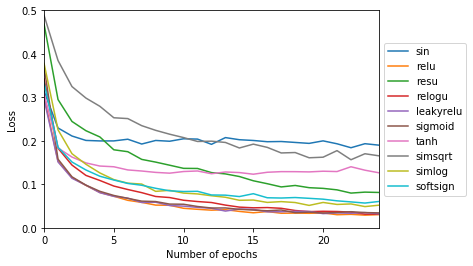

In [51]:
i = 0
for name in activations:
    
    loss = np.loadtxt(results_dir + name + '_loss.txt')
    
    plt.plot(np.arange(n_epochs), loss, c='C%d'%i, label=name)
    i += 1
    i = i % 10

plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend(fancybox=True, loc='center left', bbox_to_anchor=(1, 0.5))
plt.axis([0, n_epochs-1, 0, 0.5])
plt.savefig(results_dir + 'loss.png')
plt.show()

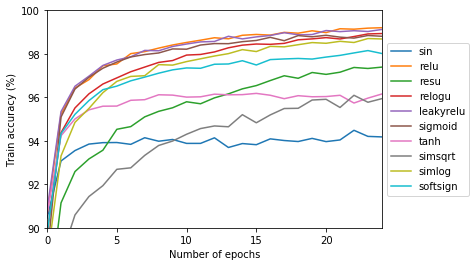

In [57]:
i = 0
for name in activations:
    
    train_acc = np.loadtxt(results_dir + name + '_train_acc.txt')
    
    plt.plot(np.arange(n_epochs), train_acc, c='C%d'%i, label=name)
    i += 1
    i = i % 10

plt.xlabel('Number of epochs')
plt.ylabel('Train accuracy (%)')
plt.legend(fancybox=True, loc='center left', bbox_to_anchor=(1, 0.5))
plt.axis([0, n_epochs-1, 90, 100])
plt.savefig(results_dir + 'train_acc.png')
plt.show()

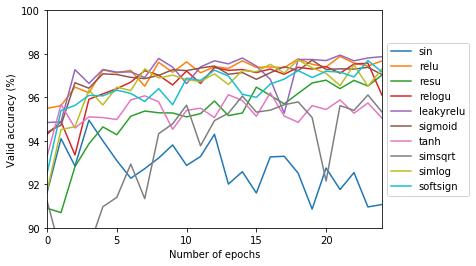

In [56]:
i = 0
for name in activations:
    
    valid_acc = np.loadtxt(results_dir + name + '_valid_acc.txt')
    
    plt.plot(np.arange(n_epochs), valid_acc, c='C%d'%i, label=name)
    i += 1
    i = i % 10

plt.xlabel('Number of epochs')
plt.ylabel('Valid accuracy (%)')
plt.legend(fancybox=True, loc='center left', bbox_to_anchor=(1, 0.5))
plt.axis([0, n_epochs-1, 90, 100])
plt.savefig(results_dir + 'train_acc.png')
plt.show()